In [1]:
import torch
import warnings
import pandas as pd
import numpy as np
import nltk
import tqdm
import json
from matplotlib import pyplot as plt

from datasets import Dataset, DatasetDict, load_metric, load_dataset

from transformers import T5Tokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq, AutoTokenizer
from evaluate import load

2023-03-24 00:26:10.156579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 00:26:10.854052: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/targets/x86_64-linux/lib:/usr/local/lib:/usr/lib:/opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cud

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
nltk.download('punkt')
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Data

In [3]:
df = pd.read_excel('../WOT_extractive_final.xlsx')

df.to_csv('temp.csv')
df = pd.read_csv('temp.csv').rename(columns={'Unnamed: 0': 'id'}).drop(columns=['Unnamed: 0.1'])
df['id'] = df['id'].astype(str)

df['output'] = df['output'].fillna('unanswerable')

# !!!!!!!!!!!!!!!!!!!!!!
# CHANGE CONTEXT
# df['input'] = df['input_context_selected']
# df['input'] = df.apply(lambda row: f"{row['question']}SPLITHistory: {row['history']}", axis=1)
# !!!!!!!!!!!!!!!!!!!!!!

df = df[['id', 'domain', 'labels', 'input', 'output', 'data_split', 'is_factoid', 'is_confirmation', 'is_complex', 'is_causal', 'is_listing', 'is_history', 'is_navigation', 'is_unanswerable']].fillna('')

df_train = df[df['data_split'] == 'train']
df_val = df[df['data_split'] == 'validation']
df_test = df[df['data_split'] == 'test']

ds_train = Dataset.from_pandas(df_train)
ds_val = Dataset.from_pandas(df_val)
ds_test = Dataset.from_pandas(df_test)
ds_wot = DatasetDict({'train': ds_train, 'validation': ds_val, 'test': ds_test,})

## Load Model and other Functions

In [4]:
model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model_dir = f"Models/{model_name}/Context_full/"

In [5]:
prefix = "question: "
max_input_length = 512
max_target_length = 50

def clean_text(text):
    question = nltk.sent_tokenize(text.split('SPLIT')[0])
    sentences = nltk.sent_tokenize(text.split('SPLIT')[1])
    text_cleaned = "\n ".join([" ".join(question).lower(), " ".join(sentences).lower()])
    return text_cleaned

def preprocess_data(examples):
    texts_cleaned = [clean_text(text) for text in examples["input"]]
    inputs = [prefix + text for text in texts_cleaned]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["output"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

def preprocess_test(examples):
    texts_cleaned = [clean_text(text) for text in examples["input"]]
    inputs = [prefix + text for text in texts_cleaned]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True,
                            padding="max_length", return_tensors="pt")
    return model_inputs

metric = load_metric('rouge')
exact_match_metric = load("exact_match")

def compute_metrics(eval_pred, eval_test = False):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels_raw = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
                      for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) 
                      for label in decoded_labels_raw]
    decoded_labels_list = [["\n".join(nltk.sent_tokenize(label.strip()))] 
                      for label in decoded_labels_raw]
        
    # Compute ROUGE scores
    result = metric.compute(predictions=decoded_preds, references=decoded_labels,
                            use_stemmer=True)
    
    # Extract ROUGE f1 scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    #result['bleu'] = bleu.compute(predictions=decoded_preds, references=decoded_labels_list)['bleu']
    result['exact_match'] = exact_match_metric.compute(predictions=decoded_preds, references=decoded_labels)['exact_match']
    #result_bert_score = bert_score.compute(predictions=decoded_preds, references=decoded_labels_list, lang="en")['f1']
    #result['bert_score (avg. F1)'] = sum(result_bert_score) / len(result_bert_score)
    
    # Add mean generated length to metrics
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
                      for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
        
    if eval_test:
        return {k: round(v, 4) for k, v in result.items()}, decoded_preds

    with open(model_dir + 'logging.txt', 'a') as log:
        log.write(str({k: round(v, 4) for k, v in result.items()}) + "\n")
    return {k: round(v, 4) for k, v in result.items()}

## Training Parameters

In [6]:
per_device_eval_batch_size = 64     #64
per_device_train_batch_size = 16     #16
gradient_accumulation_steps = 4     # per_device_train_batch_size * gradient_accumulation_steps=64 change here to be 64

args = Seq2SeqTrainingArguments(
    model_dir,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    learning_rate=4e-5,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    weight_decay=0.01,
    predict_with_generate=True,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    max_steps=5000,
    optim='adafactor',
    disable_tqdm=False
)

data_collator = DataCollatorForSeq2Seq(tokenizer)

def model_init():
    return AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).to(device)

## Fine Tune

free gpu memory: 
- nvidia-smi
- sudo kill -9 PID

In [7]:
# Set to wherever finetuning continues and where it is supposed 
# to be stored

model_checkpoint = model_name
model_dir = model_dir

tokenized_train = ds_wot['train'].map(preprocess_data, batched=True)
tokenized_dev = ds_wot['validation'].map(preprocess_data, batched=True)

A Jupyter Widget

/home/ubuntu/QuestionAnswering/project-env/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


A Jupyter Widget

# CLEAR LOGGING.TXT

In [8]:
trainer = Seq2SeqTrainer(
    model_init=model_init,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_dev,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

loading configuration file config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--t5-base/snapshots/0db7e623bcaee2daf9b859a646637ea39bf016cd/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size"

Step,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: is_navigation, is_confirmation, is_causal, is_unanswerable, __index_level_0__, id, is_listing, output, input, is_history, is_factoid, domain, is_complex, data_split. If is_navigation, is_confirmation, is_causal, is_unanswerable, __index_level_0__, id, is_listing, output, input, is_history, is_factoid, domain, is_complex, data_split are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 167
  Batch size = 64
***** Running Evaluation *****
  Num examples = 167
  Batch size = 64
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"

KeyboardInterrupt: 

## Evaluate

In [9]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model_checkpoint = model_dir + 'checkpoint-200'
ds_test = ds_wot['test']
print(model_checkpoint)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Models/t5-base/Context_full/checkpoint-200


In [10]:
def preprocess_test(examples):
    texts_cleaned = [clean_text(text) for text in examples["input"]]
    inputs = [prefix + text for text in texts_cleaned]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True,
                            padding="max_length", return_tensors="pt")
    return model_inputs

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).to(device)

test_tokenized_dataset = ds_test.map(preprocess_test, batched=True)

# prepare dataloader
test_tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])
dataloader = torch.utils.data.DataLoader(test_tokenized_dataset, batch_size=64, pin_memory=True)

# generate text for each batch
all_predictions = []
for i,batch in enumerate(dataloader):
  batch = {k: v.to(device) for k, v in batch.items()}
  predictions = model.generate(**batch)
  all_predictions.append(predictions.cpu().numpy())

# flatten predictions
all_predictions_flattened = [pred for preds in all_predictions for pred in preds]

# tokenize and pad titles
all_titles = tokenizer(test_tokenized_dataset["output"], max_length=max_target_length,
                       truncation=True, padding="max_length")["input_ids"]

# compute metrics
predictions_labels = [all_predictions_flattened, all_titles]
scores, predictions = compute_metrics(predictions_labels, eval_test=True)

df_test['predictions'] = predictions

df_test['EM'] = df_test['predictions'] == df_test['output']
df_test['pred_in_exp'] = df_test.apply(lambda row: len(row['predictions']) / len(row['output']) if row['predictions'] in row['output'] else 0, axis=1)
df_test['exp_in_pred'] = df_test.apply(lambda row: len(row['output']) / len(row['predictions']) if row['output'] in row['predictions'] else 0, axis=1)

print(scores)
print(f"Prediction in Epxectation: {df_test['pred_in_exp'].mean()}")
print(f"Epxectation in Prediction: {df_test['exp_in_pred'].mean()}")

df_test.to_excel(model_dir + 'test_set_predictions.xlsx')

with open(model_dir + 'test_evaluation.txt', 'a') as f:
  f.write('Class|elements in class|EM|elements in cooking|EM cooking|elements in diy|EM diy\n')
  for q_class in ['is_factoid', 'is_confirmation', 'is_complex', 'is_causal', 'is_listing', 'is_history', 'is_navigation']:
    df_t_cooking = df_test[(df_test[q_class] == True) & (df_test['domain']=='cooking')] 
    df_t_diy = df_test[(df_test[q_class] == True) & (df_test['domain']=='diy')]
    df_t = df_test[df_test[q_class] == True]
    f.write(f'{q_class}|{len(df_t)}|{df_t["EM"].sum()/len(df_t)}|{len(df_t_cooking)}|{df_t_cooking["EM"].sum()/len(df_t_cooking)}|{len(df_t_diy)}|{df_t_diy["EM"].sum()/len(df_t_diy)}\n')
  f.write('\n\n')
  
  f.write('Class|elements in class|Pred_in_Exp|elements in cooking|Pred_in_Exp cooking|elements in diy|Pred_in_Exp diy\n')
  for q_class in ['is_factoid', 'is_confirmation', 'is_complex', 'is_causal', 'is_listing', 'is_history', 'is_navigation']:
    df_t_cooking = df_test[(df_test[q_class] == True) & (df_test['domain']=='cooking')] 
    df_t_diy = df_test[(df_test[q_class] == True) & (df_test['domain']=='diy')]
    df_t = df_test[df_test[q_class] == True]
    f.write(f'{q_class}|{len(df_t)}|{df_t["pred_in_exp"].mean()}|{len(df_t_cooking)}|{df_t_cooking["pred_in_exp"].mean()}|{len(df_t_diy)}|{df_t_diy["pred_in_exp"].mean()}\n')
  f.write('\n\n')
  
  f.write('Class|elements in class|Exp_in_Pred|elements in cooking|Exp_in_Pred cooking|elements in diy|Exp_in_Pred diy\n')
  for q_class in ['is_factoid', 'is_confirmation', 'is_complex', 'is_causal', 'is_listing', 'is_history', 'is_navigation']:
    df_t_cooking = df_test[(df_test[q_class] == True) & (df_test['domain']=='cooking')] 
    df_t_diy = df_test[(df_test[q_class] == True) & (df_test['domain']=='diy')]
    df_t = df_test[df_test[q_class] == True]
    f.write(f'{q_class}|{len(df_t)}|{df_t["exp_in_pred"].mean()}|{len(df_t_cooking)}|{df_t_cooking["exp_in_pred"].mean()}|{len(df_t_diy)}|{df_t_diy["exp_in_pred"].mean()}\n')
  f.write('\n\n')
  
  f.write(str(df_test.groupby('domain').sum().reset_index()[['domain', 'EM']]))
  

# plot EM over training



loading file spiece.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file Models/t5-base/Context_full/checkpoint-200/config.json
Model config T5Config {
  "_name_or_path": "Models/t5-base/Context_full/checkpoint-200",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,


A Jupyter Widget

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

/home/ubuntu/QuestionAnswering/project-env/lib/python3.8/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,


{'rouge1': 36.5288, 'rouge2': 27.6113, 'rougeL': 35.6035, 'rougeLsum': 35.4355, 'exact_match': 0.1286, 'gen_len': 11.5704}
Prediction in Epxectation: 0.1615607918735406
Epxectation in Prediction: 0.16480474708949786


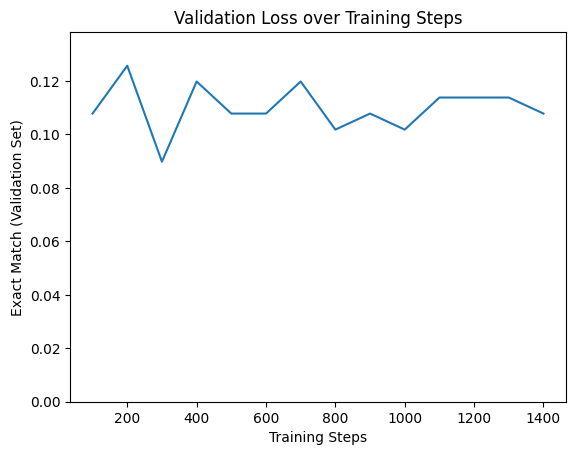

<Figure size 640x480 with 0 Axes>

In [12]:
with open(model_dir + "logging.txt", "r") as file:
    contents = file.read()

list_of_dicts = []
for line in contents.split("\n"):
    if line.strip() != "":
        dict_str = line.strip()
        dict_obj = eval(dict_str)
        list_of_dicts.append(dict_obj)
    
list_of_EM = [d['exact_match'] for d in list_of_dicts]
epochs = [(i+1) * 100 for i in range(len(list_of_EM))]

plt.plot(epochs, list_of_EM)
plt.ylim(ymax = 1.1 * max(list_of_EM), ymin = 0)
plt.title('Validation Loss over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Exact Match (Validation Set)')
plt.show()
plt.savefig(model_dir + 'Training_Validation_Loss.png')